# La régression logistique

La présentation précédante montrait comment la régression linéaire pouvait être considérée comme une première application d'apprentissage automatique. Cette présentation va maintenant présenter la [régression logistique](https://fr.wikipedia.org/wiki/R%C3%A9gression_logistique) qui est une autre forme de régression, mais avec un objectif différent.

Le problème qui est posé ici n'est plus de trouver une équation qui permettrait de représenter un nuage de point, mais de caractégoriser une population par rapport à des catégories en nombre discret (ou ce peut être simplement un vrai/faux).

Cette méthode tire son nom de la fonction [logit](https://fr.wikipedia.org/wiki/Logit) qui est utilisé dans cette méthode. L'expression de cette fonction est la suivante.

$$\text{logit}(p) = ln\left(\frac{p}{1-p}\right)$$

où $p$ est défini sur $]0, 1[$. La base du logarithme n'a pas d'importance, tant qu'elle est supérieure à 1. On peut choisir le logarithme népérien où à base 10.

Voici son graphe en utilisant cette fois l'extension [plotly](https://plotly.com/python/).

In [3]:
import plotly.graph_objects as go
import numpy as np
import plotly.io as pio

# mon style personnalisé pour les graphiques
fond_gris = {
  'layout': go.Layout(
            title={'font_size':24, 'font_color':'black'},
            margin={'t': 60, 'b': 10, 'l': 20, 'r': 20},
            paper_bgcolor='gray',
            plot_bgcolor='lightgray'
  )
}
# plus d'info sur les personnalisations graphiques sur :
# https://plotly.com/python/templates/

# déclaration d'une série de points
p = np.arange(0.01, 1, 0.01)

# création de notre figure
fig = go.Figure(data=go.Scatter(x=p, y=np.log(p/(1-p))))

# mise à jour d'un titre et de la personnalisation
fig.update_layout(title='la fonction logit',
                  template=fond_gris)
fig.show()

Outre ces asymptote et sa valeur nulle en $\frac{1}{2}$, cette fonction a quelques propriétés intéressantes.

Sa dérivée :

$$ \frac{d}{dx}\text{logit}(x) = \frac{1}{x} - \frac{1}{x-1} $$

et son intégrale :

$$ \int_0^x \text{logit}(t) dt = x \cdot \text{logit}(x) + \ln (1-x) $$

La fonction [logit](https://fr.wikipedia.org/wiki/Logit) a comme fonction réciproque de fonction [Sigmoïde](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde_(math%C3%A9matiques)).

$$\sigma(x) = \frac{1}{1 + e^{-x}} $$

In [4]:
x = np.arange(-6, 6, 0.1)

fig = go.Figure(data=go.Scatter(x=x, y=1/(1+np.exp(-x))))
fig.update_layout(title='la fonction Sigmoïde',
                  template=fond_gris)

fig.show()

On généralise cette fonction [Sigmoïde](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde_(math%C3%A9matiques)) en introduisant un paramètre $theta$.

$$\sigma_\theta(x) = \frac{1}{1+e^{-\theta x}}$$

Cette fonction  possède certaines propriétés intéressante comme pour sa dérivée.

$$\frac{d\sigma_\theta(x)}{dx} = \frac{\theta e^{-\theta x}}{\left(1+e^{-\theta x}\right)^2}$$

Si on pose $y = \sigma_theta(x)$, on peut ré-écrire cette dérivée ainsi.

$$\frac{dy}{dx} = \theta\cdot y \cdot (1 - y)$$

Avec donc $y$ variant entre 0 et 1. 

Reprenons le cas où $\theta = 1$, la dérivée de cette fonction Sigmoïde en est la probabilité d'arriver à cette valeur et pas au dessus.

Cette expression sera ensuite réutilisée plus bas pour la méthode utilisant la descente du gradient.

L'intérêt de cette fonction est qu'à partir d'une population distribuée sur l'axe x et se répartissant déjà à peu près sur deux groupes (les petites valeurs et les grandes valeurs), on peut définir un seuil placé judicieument "au milieu", qui départagera des résultats entre 0 et 1.

![départage par sigmoïde](./img/departage_sigmoide.png)

La fonction Sigmoïde va permettre de renforcer la clarté de réponse oui ou non à la question posée.

# Analyse d'un échantillon séparable

*(cette partie est reprise d'une partie [d'article sur le régression venant de l'université de Montpelier](https://www.univ-montp3.fr/miap/ens/miashs/master/ues/test_maximilien/htmls/3_classification/1_logistic_regression.html))*

Nous nous donnons un échantillon qui suit une loi Normale à trois dimensions $\beta \sim \mathcal{N}(0,1)^3 \in \mathbb{R}^3$

Cette distribution peut être obtenue avec [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) qui nous permet d'obtenir un vecteur d'une taille donné suivant cette distribution.

In [5]:
import numpy as np
real_beta = np.random.normal(0, 1, size=3)
real_beta[1:3]

array([ 1.26051474, -2.03148657])

On peut ensuite afficher cette distribution en utilisant [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.displot.html) qui est spécialisée dans l'affichage des distributions.

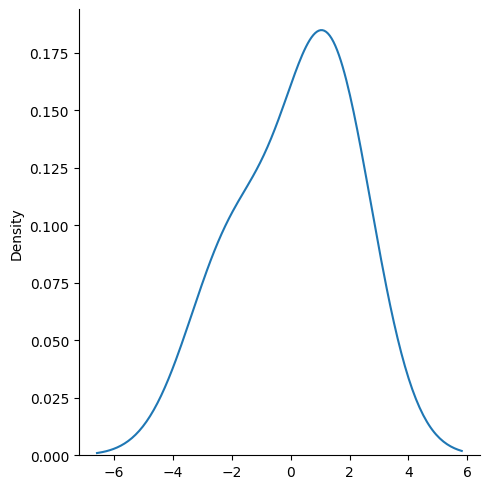

In [6]:
import seaborn as sns
sns.displot(real_beta, kind="kde")

L'extension [numpy propose maintenant une nouvelle méthode](https://numpy.org/doc/stable/reference/random/index.html#random-quick-start) en utilisant un générateur de nombres aléatoires `rng` et lui appliquant ensuite une [distribution normale](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal) ou [standard normale](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.standard_normal.html#numpy.random.Generator.standard_normal).

In [7]:
rng = np.random.default_rng()
vals = rng.standard_normal(10)
vals[0:3]

array([-1.68074932, -0.44635712, -1.35014108])

On va choisir un échantillons sur $\mathbb{R}³$ en projetant sur le plan de deux dernières coordonnées.

$$\beta' = \left[\begin{array}{c}
                   \beta_1 \\ \beta_2
                  \end{array}\right] $$

et on renormalise la longueur:

$$ \mu = \beta' \left( -\frac{\beta_0}{\left\lVert\beta'\right\rVert^2}\right)$$

de telle sorte que

$$ \beta' \bullet \mu + \beta_0 = 0$$

Cette dernière équation va nous donner une règle de séparation de nos échantillons normaux.

Pour passer ces équations en Python, il nous faudra utiliser le produit scalaire de deux vecteurs, ce qui se fait avec la fonction [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) et la norme d'un vecteur qui se fait avec [numpy.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html). À partir du vecteur `real_beta` qu'on s'est donné plus haut, on calcule $\mu$ et on peut vérifier l'égalité qu'on a montrée.

In [8]:
beta = real_beta
mu = beta[1:3]*(-beta[0]/(np.linalg.norm(beta[1:3])**2))
np.dot(beta[1:3], mu) + beta[0]

-2.220446049250313e-16

Le vecteur $\beta = [\beta_0, \beta_1, \beta2]$ est maintenant fixé. On se donne maintenant un échantillon de $\mathbb{R}^2$ suivant une loi normale.

$$ x \sim \mathcal{N}(\mu,1) \in \mathbb{R}^2 $$

Et on définit une catégorisation selon la règle suivante

$$ y_i = \left\{ 
         \begin{array}{lll}
         1 & \text{si} & \beta' \bullet x_i + \beta_0 > 0 \\
         0 & \text{sinon} &\\
         \end{array}     
         \right. $$

On obtient donc des données qui par construction seront séparrées linéairement par le vecteur normal $\beta'$ et le biais $\beta_0$.

En Python, nous utiliserons la fonction [numpy.random.RandomState.multivariate_normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.multivariate_normal.html#numpy.random.RandomState.multivariate_normal) pour générer la population $(x_i)_i$ de variables à deux dimensions, chacune des dimensions suivant une loi Normale. Le vecteur $\mu$ nous a été donné, pour le covariance nous prenons un vecteur constitué que de 1, ce qu'on obtient avec la fonction [numpy.ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) qu'on diagonalise avec [numpy.diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) pour obtenir le vecteur des covariances.

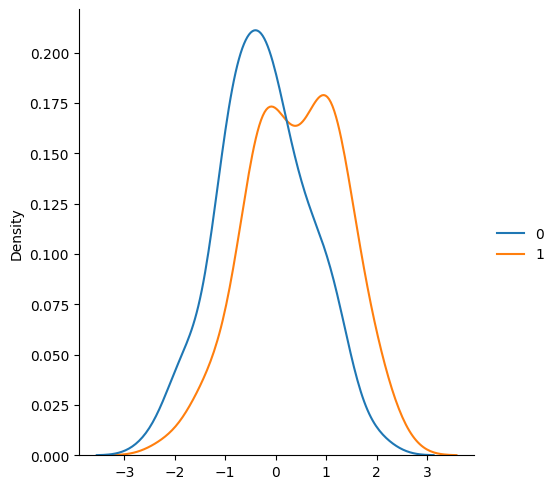

In [9]:
cov = np.diag(np.ones(2))
n = 100
x = np.random.default_rng().multivariate_normal(mu,cov,n)
# affichage de la distribution des deux variables aléatoires
sns.displot(x, kind="kde")

On construit donc notre échantillon avec la fonction suivante qui utilise la fonction [numpy.insert](https://numpy.org/doc/stable/reference/generated/numpy.insert.html) pour ajouter

In [11]:
def sample_data(n, beta):
    # construction du vecteur servant à séparer
    mu = beta[1:3]*(-beta[0]/(np.linalg.norm(beta[1:3])**2))
    # les covariances
    cov  = np.diag(np.ones(2))
    # la génération de la population (x)
    X = np.insert(np.random.default_rng().multivariate_normal(mu,cov,n),0,1,axis=1)
    # détermination de la catégorie du x tiré
    y = (np.dot(X, beta)>0)*1
    return X, y

X, y = sample_data(100, real_beta)

On affiche maintenant le résultat, la population séparrée en deux clans de couleurs différentes et la droite les séparant. On utilise la fonction [matplotlib.pyplot.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) qui représente un nuage de point.


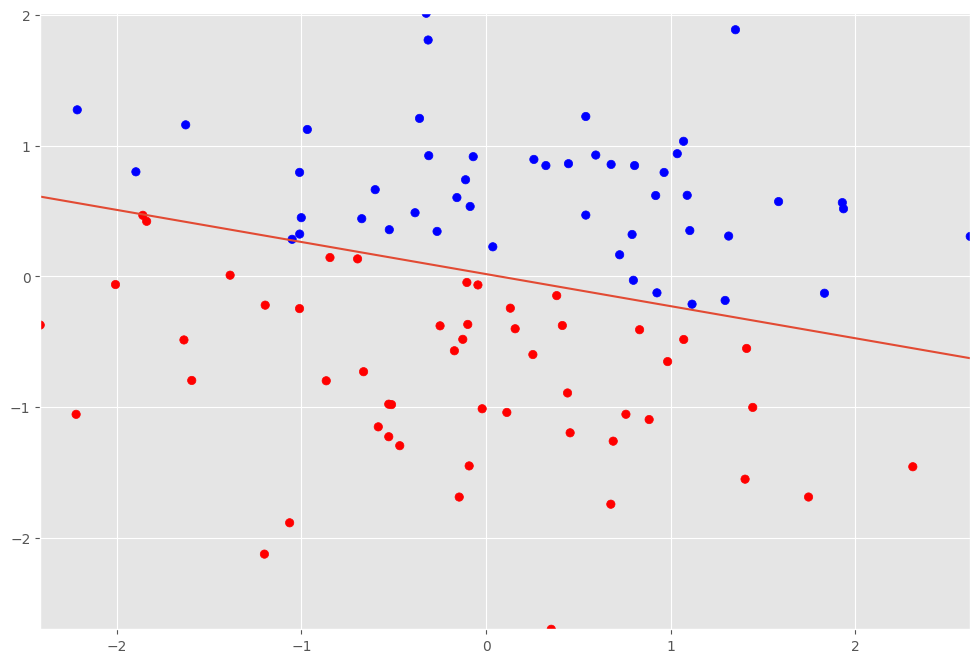

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

def plot(X, y, beta=None, predictor=None, title=None):
    ymin_ = X[:,2].min()
    ymax_ = X[:,2].max()
    min_ = X[:,1].min()
    max_ = X[:,1].max()
    
    if predictor is not None:
        h = 0.02
        xx, yy = np.meshgrid(np.arange(min_, max_, h), np.arange(ymin_, ymax_, h))
        Z = predictor.predict(np.insert(np.c_[xx.ravel(), yy.ravel()], 0, 1, axis=1))
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z,shading='auto', alpha=0.01)

    # Construction de la liste des couleurs à donner aux points.
    # Ces couleurs sont en fonction de 'y' qui peut être
    # égale à 0 ou 1.
    C=[]
    for i in y:
        if i==0:
            C.append('r')
        else:
            C.append('b')
    # impression du nuage de points
    plt.scatter(X[:,1], X[:,2],c=C)
    
    # impression de la droite de séparation
    if beta is not None:
        x_ = np.linspace(min_, max_, 500)
        y_  = -beta[0]/beta[2] - x_ * beta[1] / beta[2]
        plt.plot(x_, y_)
    
    if title is not None:
        plt.title(title)
    plt.xlim(min_, max_)
    plt.ylim(ymin_, ymax_)
    plt.show()
plot(X, y, real_beta)

On peut relancer le calcul de toutes les cellules et ce graphe va changer. En effet, la règle définissant les paramètres $\mu$ se fait aléatoirement, puis on tire une population $(x_i)_i$ aussi tirée aléatoirement et qui sera séparée par la droite définie par $\mu$.

# Fonction objectif et gradient



# Analyse multifactorielle

Avec une multitude de facteur, on applique cette fonction Sigmoïde aux différentes entrées $X_k=(x_{(k,i)})_i$ avec des coefficients $\theta_k$.

![entrées fonction sigmoïde](./img/TJSLL8DR0K.png)

Chaque $X_1, X_2, X_3, X4$ de ce schéma est en fait une population d'entrées observées $X_1 = (x_{1,i})_{i \in \{1..m\}}$, qui sont donc représentées par un vecteur de $\mathbb{R}^m$. Ces quatres populations (qu'on généralisera par $n$) sont ensuite pondérée par des paramètres $\Theta = (\theta_k)_{k \in \{1..n\}}$.

 Si on généralise la fonction Sigmoïde que nous avons vu, nous remplaçons le paramètre réel par le vecteur $X_k$ à multiplier par un pondération $\theta_k$, on obient la formule suivante :

$$\forall X_k = (x_{k,i})_i \in \mathbb{R}^n \quad \sigma_k(X_k) = \frac{1}{1 + e^{-\sum_{i=1}^n \theta_k x_{k,i}}}$$


https://www.miximum.fr/blog/affaire-de-logistique/

# Utilisation de l'extension `Slit learn`

L'extension [SciKit Learn](https://scikit-learn.org/stable/index.html) offre un module de régression logistique.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

NameError: name 'X_train' is not defined

liens:
https://datascientest.com/regression-logistique-quest-ce-que-cest

https://www.univ-montp3.fr/miap/ens/miashs/master/ues/test_maximilien/htmls/3_classification/1_logistic_regression.html

https://spss.espaceweb.usherbrooke.ca/regression-logistique/

https://www.miximum.fr/blog/affaire-de-logistique/
